# Make multiwavelength light curves using archival data
***

## Learning Goals    
By the end of this tutorial, you will be able to:
 - automatically load a catalog of sources
 - automatically search NASA and non-NASA resources for light curves
 - store light curves in a Pandas multiindex dataframe
 - plot all light curves on the same plot
 
 
## Introduction:
 - A user has a sample of interesting targets for which they would like to see a plot of available archival light curves.  We start with a small set of changing look AGN from Yang et al., 2018, which are automatically downloaded. Changing look AGN are cases where the broad emission lines appear or disappear (and not just that the flux is variable). We model light curve plots after van Velzen et al. 2021.  We search through a curated list of time-domain NASA holdings as well as non-NASA sources.  HEASARC catalogs used are Fermi and Beppo-Sax, IRSA catalogs used are ZTF and WISE, and MAST catalogs used are Pan-Starrs, TESS, Kepler, and K2.  Non-NASA sources are Gaia and IceCube. This list is hopefully generalized enough to include many types of targets to make this notebook interesting for many types of science.  All of these time-domain archives are searched in an automated fashion using astroquery.
 - Light curve data storage is a tricky problem.  Currently we are using a multi-index Pandas dataframe, but it is not clear that this is the best choice or the best choice for scaling up.  One downside is that we need to manually track the units of flux and time instead of relying on an astropy storage scheme which would be able to do the units worrying for us.  Astropy does not currently have a good option for multi band light curve storage.
 - We intend to explore two possible extensions to this project.  The first is an image extension where we would search the archives for images of these sources.  The second, is exploring a ML classifier for these changing look AGN light curves.
 
## Input:
 - a catalog of CLAGN from the literature

## Output:
 - an archival optical + IR + neutrino light curve
 
## Technical Goals:
 - should be able to run from a clean checkout from github
 - should be able to automatically download all catalogs & images used
 - need to have all photometry in the same physical unit
 - need to have a data structure that is easy to use but holds light curve information (time and units) and is extendable to ML applications
 - need to have a curated list of catalogs to search for photometry that is generalizeable to other input catalogs
 
## Non-standard Imports:
- `astroquery` to interface with archives APIs
- `astropy` to work with coordinates/units and data structures
- `AXS` (astronomy extensions for Spark) to handle large catalog cross matching
- `lightkurve` to search TESSS, Kepler, and K2 archives
- `urllib` to handle archive searches with website interface

## Authors:
IPAC SP team

## Acknowledgements:
Suvi Gezari, Antara Basu-zych,\
MAST, HEASARC, & IRSA Fornax teams



In [1]:
import numpy as np
import time
import pandas as pd
import axs
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import requests

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries


try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

#!pip install lightkurve --upgrade
import lightkurve as lk

#!pip install acstools
from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

## From Brigitta
class MultibandTimeSeries(TimeSeries):
    def __init__(self, *, data=None, time=None, **kwargs):
        # using kwargs to swallow all other arguments a TimeSeries/QTable can have,
        # but we dont explicitly use. Ideally they are spelt out if we have docstrings here.
        # Also using keyword only arguments everywhere to force being explicit.
        super().__init__(data=data, time=time, **kwargs)
                
    def add_band(self, *, time=None, data=None, band_name="None"):
        '''Add a time, flux/mag data set and resort the arrays. ``time`` can be a TimeSeries instance'''
        if 'time' not in self.colnames:
            if isinstance(time, TimeSeries):
                super().__init__(time)
            else:
                super().__init__(data={band_name: data}, time=time)
        else:
            if time is None:
                # this assumes ``band_name`` fluxes are taken at the very same times as the already exitsing bands
                # TODO: include checks for sizes and other assumptions
                self[band_name] = data
                return 
            elif not isinstance(time, TimeSeries):
                # TODO: handle band_name=None case
                time = TimeSeries(time=time, data={band_name: data})
            super().__init__(vstack([self, time]))
            
            
## MultiIndex Pandas data frame object in which we can append the light curves:
class MultiIndexDFObject:
    '''
    Pandas data frame MultiIndex object. 
    - add(): append new MultiIndex light curve data frame.
    - .data returns the data.
    '''
    def __init__(self):
        pass
    
    def append(self,x):
        try:
            self.data
        except AttributeError:
            self.data = x.copy()
        else:
            self.data = pd.concat([self.data , x])


## Plotting stuff
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['xtick.major.pad'] = 7
mpl.rcParams['ytick.major.pad'] = 7
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.top'] = True
mpl.rcParams['xtick.minor.bottom'] = True
mpl.rcParams['ytick.minor.left'] = True
mpl.rcParams['ytick.minor.right'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1
def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']



## 1. Define the Sample
 use the following paper to make a sample of CLAGN: https://iopscience.iop.org/article/10.3847/1538-4357/aaca3a 

 This sample can later be switched out to a differen/larger sample of "interesting" targets


In [2]:
#use ADS to find the refcode for this paper (ie., '2018blahblah')
#Then use the NED astroquery interface to load the table from the paper with relevant target info
#This loads the table into an astropy table

CLAGN = Ned.query_refcode('2018ApJ...862..109Y')



In [3]:
#see what is included in this table
CLAGN

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J000107.52-000552.5,0.28136,-0.09789,G,59147.0,0.197292,SPEC,19.7g,--,6,0,34,8,5,4,0
2,WISEA J012648.10-083948.0,21.70037,-8.66335,G,59333.0,0.197913,SPEC,18.6g,--,22,0,62,14,8,8,0
3,2MASS J01595763+0033105,29.99,0.55301,QSO,93546.0,0.312036,SPEC,19.6g,--,63,0,76,17,19,10,0
4,WISEA J015957.63+003310.3,29.99015,0.55288,IrS,93547.0,0.31204,SLS,,--,4,0,12,3,2,0,0
5,WISEA J080347.56+425839.0,120.94815,42.97747,G,125547.0,0.418778,SPEC,21.8g,--,4,0,27,5,3,4,0
6,WISEA J083132.25+364617.0,127.88438,36.77146,G,58463.0,0.19501,SPEC,18.8g,--,17,0,62,9,7,10,0
7,WISEA J084957.78+274728.8,132.49077,27.79139,QSO,89499.0,0.298537,SPEC,19.1g,--,23,0,65,12,11,8,0
8,WISEA J090932.02+474730.7,137.38346,47.79186,G,35059.0,0.116944,SPEC,18.7g,--,19,0,53,8,6,8,1


In [4]:
#Build a list of skycoords from target ra and dec
#This is useful for some codes which understand that these are a set of coordinates
coords_list = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(CLAGN['RA'], CLAGN['DEC'])
]


In [5]:
#Here are additional CLAGN samples
CLQ = Ned.query_refcode('2022ApJ...933..180G') #from Green et al., 2022

green_coords = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(CLQ['RA'], CLAGN['DEC'])
]

CSAGN = Ned.query_refcode('2021AJ....162..206S') # from Sanchez-Saez 2021

ss_coords = [
    SkyCoord(ra, dec, frame='icrs', unit='deg')
    for ra, dec in zip(CSAGN['RA'], CSAGN['DEC'])
]


In [6]:
#use astropy table to get larger sample that neither NED nor astropy can access.
CSQ = Table.read('https://academic.oup.com/mnras/article/491/4/4925/5634279', htmldict={'table_id': 5}, format='ascii.html')

#get coords from "name" column for this
graham_coords = []
for i in range(len(CSQ)):
    coord_str = CSQ['Name\n            .'][i]
    test_str = coord_str[6:8]+ " "+ coord_str[8:10]+ " " + coord_str[10:14] + " " + coord_str[14:17] + " " + coord_str[17:19]+ " " + coord_str[19:]
    graham_coords.append(SkyCoord(test_str, unit=(u.hourangle, u.deg)))


In [7]:
#when ready for more than the initial sample of 30
#coords_list.extend(green_coords)
#coords_list.extend(ss_coords)
#coords_list.extend(graham_coords)


In [5]:
### Initialize Pandas MultiIndex data frame for storing the light curve
df_lc = MultiIndexDFObject()

## 2. Find light curves for these targets in NASA catalogs
- data access concerns:
    - can't ask the archives to search their entire holdings
        - not good enough meta data
        - not clear that the data is all vetted and good enough to include for science
        - all catalogs have differently named columns so how would we know which columns to keep
    - instead work with a curated list of catalogs for each archive
        - focus on general surveys
        - try to ensure that this list is also appropriate for a generalization of this use case to other input catalogs
        - could astroquery.NED be useful in finding a generalized curated list


### 2.1 HEASARC: FERMI & Beppo SAX


In [9]:
mission_list = ['FERMIGTRIG', 'SAXGRBMGRB']
radius = 0.1*u.degree
#for testing
for ccount in range(1):
    #To get a fermigtrig source
    #coord = SkyCoord('03h41m21.2s -89d00m33.0s', frame='icrs')

    #to get a bepposax source
    coord = SkyCoord('14h32m00.0s -88d00m00.0s', frame='icrs')

#for ccount, coord in enumerate(coords_list):
    #use astroquery to search that position for either a Fermi or Beppo Sax trigger
    for mcount, mission in enumerate(mission_list):
        try:
            results = Heasarc.query_region(coord, mission = mission, radius = radius)#, sortvar = 'SEARCH_OFFSET_')
            #really just need to save the one time of the Gamma ray detection
            #time is already in MJD for both catalogs
            if mission == 'FERMIGTRIG':
                time_mjd = float(results['TRIGGER_TIME'])
            else:
                time_mjd = float(results['TIME'][0])
                
            type(time_mjd)

            #really just need to mark this spot with a vertical line in the plot
            dfsingle = pd.DataFrame(dict(flux=[0.1], err=[0.1], time=[time_mjd], objectid=[ccount + 1], band=[mission])).set_index(["objectid", "band", "time"])
            
            # Append to existing MultiIndex light curve object
            df_lc.append(dfsingle)

        except AttributeError:
            print("no results at that location for ", mission)


#**** These HEASARC searches are returning an attribute error because of an astroquery bug
# bug submitted to astroquery Oct 18, waiting for a fix.
# if that gets fixed, can probably change this cell 

no results at that location for  FERMIGTRIG


In [10]:
df_lc.data

,,,flux,err
objectid,band,time,,
1,SAXGRBMGRB,52013.991319,0.1,0.1


### 2.2 IRSA: ZTF

In [11]:
%%time
#python package ztfquery is not a good solution for this because it requires IRSA password
#Instead will construct the URL for an API query
#https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html
ztf_radius = 0.000278   #as suggested by Dave Shupe

for ccount, coord in enumerate(coords_list):
    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]
    #make the string for the URL query
    #ask for all three bands (g, r, i)
    #don't want data that is flagged as unusable by the ZTF pipeline
    urlstr = 'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE %f %f %f&BANDNAME=g,r,i&FORMAT=ipac_table&BAD_CATFLAGS_MASK=32768'%(ra, dec,ztf_radius)

    response = requests.get(urlstr)
    if response.ok:
        ztf_lc = ascii.read(response.text, format='ipac')
        print('object '+str(ccount)+' , unique ztf IDs:'+str(len(np.unique(ztf_lc['oid'])))+',in '+str(len(np.unique(ztf_lc['filtercode'])))+' filters')
        # reading in indecies of unique IDs to do coordinate match and find dif magnitudes of same objects 
        idu,inds = np.unique(ztf_lc['oid'],return_index=True)
        #plt.figure(figsize=(6,4))
        for nn,idd in enumerate(idu):
            sel = (ztf_lc['oid']==idd)
            
            flux = 10**((ztf_lc['mag'][sel] - 23.9)/(-2.5))  #now in uJy [Based on ztf paper https://arxiv.org/pdf/1902.01872.pdf zeropoint corrections already applied]
            magupper = ztf_lc['mag'][sel] + ztf_lc['magerr'][sel]
            maglower = ztf_lc['mag'][sel] - ztf_lc['magerr'][sel]
            flux_upper = abs(flux - (10**((magupper - 23.9)/(-2.5))))
            flux_lower =  abs(flux - (10**((maglower - 23.9)/(-2.5))))
            fluxerr = (flux_upper + flux_lower) / 2.0
            
            flux = flux * (1E-3) # now in mJy
            fluxerr = fluxerr * (1E-3) # now in mJy
            
            #plt.errorbar(np.round(ztf_lc['mjd'][sel],0),flux,yerr=fluxerr,marker='.',linestyle='',label=ztf_lc['filtercode'][sel][0])
            #plt.legend()
            
  
            # add to df_lc
            dfsingle = pd.DataFrame(dict(flux=flux, err=fluxerr, time=ztf_lc['mjd'][sel], objectid=np.ones_like(ztf_lc['mag'][sel])*(ccount+1), band=ztf_lc['filtercode'][sel])).set_index(["objectid", "band", "time"])
            df_lc.append(dfsingle)

        #plt.show()
    
    else:
        print(ccount, " There is no ZTF light curve for object"+str(ccount))

object 0 , unique ztf IDs:3,in 3 filters
object 1 , unique ztf IDs:2,in 2 filters
object 2 , unique ztf IDs:5,in 3 filters
object 3 , unique ztf IDs:5,in 3 filters
object 4 , unique ztf IDs:4,in 3 filters
object 5 , unique ztf IDs:5,in 3 filters
object 6 , unique ztf IDs:6,in 3 filters
object 7 , unique ztf IDs:4,in 2 filters
object 8 , unique ztf IDs:8,in 3 filters
object 9 , unique ztf IDs:5,in 3 filters
object 10 , unique ztf IDs:5,in 3 filters
object 11 , unique ztf IDs:8,in 3 filters
object 12 , unique ztf IDs:3,in 3 filters
object 13 , unique ztf IDs:3,in 3 filters
object 14 , unique ztf IDs:3,in 3 filters
object 15 , unique ztf IDs:5,in 3 filters
object 16 , unique ztf IDs:6,in 3 filters
object 17 , unique ztf IDs:3,in 3 filters
object 18 , unique ztf IDs:5,in 3 filters
object 19 , unique ztf IDs:5,in 3 filters
object 20 , unique ztf IDs:4,in 3 filters
object 21 , unique ztf IDs:4,in 3 filters
object 22 , unique ztf IDs:3,in 3 filters
object 23 , unique ztf IDs:1,in 1 filters
ob

### 2.3 IRSA:WISE

- Dave Shupe has made a catalog of NEOWISE light curves of half the sky in a parquet file

- Pandas is not a good option for reading in and working with this catalog because it is so large (2 billion rows?)

- Instead we can use AXS to cross match the CLAGN sample with the NEOWISE catalog to find those rows in neowise which correspond to the CLAGN sample. AXS is a part of spark. 


use the untimely catalog
https://github.com/fkiwy/unTimely_Catalog_explorer

https://iopscience-iop-org.caltech.idm.oclc.org/article/10.3847/1538-3881/aca2ab

In [ ]:
try:
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
except ImportError:
    if not os.path.exists('./unTimely_Catalog_explorer'):
        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
    sys.path.append('./unTimely_Catalog_explorer')
    from unTimely_Catalog_tools import unTimelyCatalogExplorer

In [ ]:
#%%time
#could load the neowise light curves into pandas, but would need to severely
# filter the catalog to get it to fit into memory.  Since these targets are all over the sky
# it is not obvious how to filter the catalog

#Here is one way it could work in Pandas if we had a way to filter significantly before matching
#subset = pd.read_parquet('/stage/irsa-data-download10/parquet-work/NEOWISE-R/neowise_lc_half.parquet',
#                    engine='pyarrow', 
#                    filters=[ ('ra', '<', 121) , ('ra', '>', 120) , 
#                            ('dec', '<', 68) , ('dec', '>', -9),
#                            ('cw_w1mpro', '>', 15.0) ])
#
#len(subset)

In [ ]:
#start up SPARK
os.environ['SPARK_CONF_DIR'] = '/home/jkrick/axs_store/conf_alt'

def spark_start(work_dir, database_dir, warehouse_dir):
    from pyspark.sql import SparkSession
    import os
    
    spark = (
            SparkSession.builder
            .appName("spark trial")
            .config("spark.sql.warehouse.dir", warehouse_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '64G') # 128
            .config('spark.executor.memory', '30G')
            .config('spark.local.dir', work_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '128G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "60G")
            .config("spark.driver.extraJavaOptions", 
                    f"-Dderby.system.home={database_dir}")
            .config("spark.sql.hive.metastore.sharedPrefixes",
                    "org.apache.derby")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start(
    "/stage/irsa-staff-jkrick/spark_work",
    "/home/jkrick/axs_store",
    "/stage/irsa-staff-jkrick/sp_axs_warehouse/warehouse")

In [ ]:
#if the catalog we want is not yet available, import it
catalog = axs.AxsCatalog(spark_session)
catlist = catalog.list_table_names()

if 'neowise_lc_half' not in catlist:
    catalog.import_existing_table('neowise_lc_half', 
        '/stage/irsa-data-download10/parquet-work/NEOWISE-R/neowise_lc_half.parquet',
        import_into_spark=True)
    

#now figure out how to get the CLAGN catalog into AXS
#can't go direct from astropy table into AXS, so first need to convert astropy to pandas, then to AXS

if 'axs_clagn' not in catlist:

    pd_CLAGN = CLAGN.to_pandas()

    #then pandas to spark dataframe
    sp_CLAGN = spark_session.createDataFrame(pd_CLAGN)

    #saving below can't handle capital "RA" and "DEC", so need to change that
    #also can't handle column names with spaces in them so need to rename those as well.
    sp_CLAGN2 = sp_CLAGN.withColumnRenamed("RA","ra").withColumnRenamed("DEC","dec").withColumnRenamed("Object Name", "Object_name").withColumnRenamed("Redshift Flag","redshift_flag").withColumnRenamed("Magnitude and Filter", "magnitude_and_filter").withColumnRenamed("Photometry Points","photometry_points").withColumnRenamed("Redshift Points", "redshift_points").withColumnRenamed("Diameter Points","diameter_points")

    #now save spark to AXS
    catalog.save_axs_table(sp_CLAGN2, 'AXS_CLAGN', calculate_zone=True)

In [ ]:
#just confirm that worked:
#catalog = axs.AxsCatalog(spark_session)
#catlist = catalog.list_table_names()
#catlist

In [ ]:
#lazy load in the NEOWISE and CLAGN catalog
neowise_lc_half = catalog.load('neowise_lc_half')
axs_clagn = catalog.load('axs_clagn')

#rename column name which is causing problems
axs_clagn = axs_clagn.withColumnRenamed("No.", "objnum")

In [ ]:
#lazy crossmatch CLAGN with NEOWISE

neowise_CLAGN = neowise_lc_half.crossmatch(axs_clagn, 2*axs.Constants.ONE_ASEC, return_min = True, include_dist_col = True)


In [ ]:
%%time
#lazy evaluation means the cross match won't happen until this cell gets executed
#how many matches did we get?
neowise_CLAGN.count()

In [ ]:
%%time
#result is an AXS table, but want to get it into pandas
#this is slow (18 min for limited set of columns) but is the fastest I have found

#make a smaller version with just the light curve info to save
neowise_lc = neowise_CLAGN.select('objnum','Object_name','w1pmag','w1pmagerr','w2pmag','w2pmagerr', 'mjd')

#convert to Pandas dataframe
pd_neowise_lc = neowise_lc.toPandas()



In [ ]:
#need to convert those magnitudes into flux to be consistent in data structure.
#go to Janskies
#using zeropoints from here: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html
def convert_WISEtoJanskies(mag, magerr, band):
    if band == 'w1':
        zpt = 309.54
    elif band == 'w2':
        zpt = 171.787
            
    flux_Jy = zpt*(10**(-mag/2.5))
    
    #calculate the error
    magupper = mag + magerr
    maglower = mag - magerr
    flux_upper = abs(flux_Jy - (zpt*(10**(-magupper/2.5))))
    flux_lower = abs(flux_Jy - (zpt*(10**(-maglower/2.5))))
    
    fluxerr_Jy = (flux_upper + flux_lower) / 2.0
    
    return flux_Jy, fluxerr_Jy

In [ ]:
def convert_decimal_float(changetype):

    #columns which are themselves arrays
    changetype['mjd'] = [changetype.mjd[i].astype(float) for i in range(len(changetype))]
    changetype['w1mag'] = [changetype.w1pmag[i].astype(float) for i in range(len(changetype))]
    changetype['w2mag'] = [changetype.w2pmag[i].astype(float) for i in range(len(changetype))]
    changetype['w1error'] = [changetype.w1pmagerr[i].astype(float) for i in range(len(changetype))]
    changetype['w2error'] = [changetype.w2pmagerr[i].astype(float) for i in range(len(changetype))]

    return changetype


In [ ]:
#decimals are causing problems when trying to change the units of these columns,
# so change their type to floats which are more universally useable
floats = convert_decimal_float(pd_neowise_lc)

In [ ]:
##ack, w2 errors don't have same lengths as flux arrays!!
#well, we need to exclude w2 for now and figure this out
#Dave thinks it was a problem with null values getting dropped when he made the catalog
#need to re-make the catalog in order for this to get fixed
for i in range(29):
    print(i, floats['w2mag'][i].size, floats['w2error'][i].size)

In [ ]:
#make new columns with fluxes instead of magnitudes for comparison with other bands
w1flux, w1fluxerr = convert_WISEtoJanskies(floats['w1mag'],floats['w1error'] ,'w1')
flux_lc = pd_neowise_lc.assign(w1flux = w1flux*1E3, w1fluxerr = w1fluxerr*1E3)  #in mJy

#deprecated until we get w2 uncertainties of the same length as magnitudes
#w2flux, w2fluxerr = convert_WISEtoJanskies(floats['w2mag'],floats['w2error'] ,'w2')
#flux_lc = flux_lc.assign(w2flux = w2flux*1E3, w2fluxerr = w2fluxerr*1E3)#in mJy


In [ ]:
#Save the resulting (Jy) light curves to the pandas multiindex data frame
#syntax isn't working and getting data type errors to convert the whole dataframe of arrays at once
#instead try iterating over rows in df and making individual data frames which we then concatenate together.
#this is crazy inefficient, but....I can't make it work any other way
pd_neowise_lc.reset_index()
for index, row in flux_lc.iterrows():
    dfw1 = pd.DataFrame(dict(flux=row.w1flux, err=row.w1fluxerr, time=row.mjd, objectid=row.objnum, band='w1')).set_index(["objectid", "band", "time"])

    #then concatenate each individual df together
    df_lc.append(dfw1)


In [ ]:
df_lc

### 2.4 MAST: Pan-STARRS
Code ideas taken from this website: https://ps1images.stsci.edu/ps1_dr2_api.html

In [11]:
def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)


def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = f"{baseurl}/{release}/{table}.{format}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))


def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = f"{baseurl}/{release}/{table}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def addfilter(dtab):
    """Add filter name as column in detection table by translating filterID
    
    This modifies the table in place.  If the 'filter' column already exists,
    the table is returned unchanged.
    """
    if 'filter' not in dtab.colnames:
        # the filterID value goes from 1 to 5 for grizy
        #id2filter = np.array(list('grizy'))
        id2filter = np.array(['panstarrs g','panstarrs r','panstarrs i','panstarrs z','panstarrs y'])
        dtab['filter'] = id2filter[(dtab['filterID']-1).data]
    return dtab

def improve_filter_format(tab):
# column names don't include which filter it is
    for filter in 'grizy':
        col = filter+'MeanPSFMag'
        tab[col].format = ".4f"
        tab[col][tab[col] == -999.0] = np.nan
            
    return(tab)

def search_lightcurve(objid):
    #setup to pull light curve info
    dconstraints = {'objID': objid}
    dcolumns = ("""objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,
            psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3""").split(',')
    # strip blanks and weed out blank and commented-out values
    dcolumns = [x.strip() for x in dcolumns]
    dcolumns = [x for x in dcolumns if x and not x.startswith('#')]


    #get the actual detections and light curve info for this target
    dresults = ps1search(table='detection',release='dr2',columns=dcolumns,**dconstraints)
    
    return(dresults)


In [12]:
#Do a panstarrs search
radius = 1.0/3600.0 # radius = 1 arcsec
#plt.rcParams.update({'font.size': 14})
#plt.figure(1,(10,10))

        
#for all objects in our catalog
for ccount, coord in enumerate(coords_list):
    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]

    #see if there is an object in panSTARRS at this location
    results = ps1cone(ra,dec,radius,release='dr2')
    tab = ascii.read(results)
    
    # improve the format of the table
    tab = improve_filter_format(tab)
        
    #in case there is more than one object within 1 arcsec, sort them by match distance
    tab.sort('distance')
    
    #if there is an object at that location
    if len(tab) > 0:   
        #got a live one
        #print( 'for object', ccount + 1, 'there is ',len(tab), 'match in panSTARRS', tab['objID'])

        #take the closest match as the best match
        objid = tab['objID'][0]
        
        #get the actual detections and light curve info for this target
        dresults = search_lightcurve(objid)
        
        #sometimes there isn't actually a light curve for the target???
        try:
            ascii.read(dresults)
        except FileNotFoundError:
            print("There is no light curve")
            #no need to store PanSTARRS data for this one
        else:
            #There is a light curve for this target
            
            #fix the column names to include filter names
            dtab = addfilter(ascii.read(dresults))
            dtab.sort('obsTime')

            #here is the light curve mixed from all 5 bands
            t_panstarrs = dtab['obsTime']
            flux_panstarrs = dtab['psfFlux']*1E3  # in mJy
            err_panstarrs = dtab['psfFluxErr'] *1E3
            filtername = dtab['filter']
            
            #put this single object light curves into a pandas multiindex dataframe
            dfsingle = pd.DataFrame(dict(flux=flux_panstarrs, err=err_panstarrs, time=t_panstarrs, objectid=ccount + 1, band=filtername)).set_index(["objectid", "band", "time"])
            
            #then concatenate each individual df together
            df_lc.append(dfsingle)
                
            


In [8]:
dtab

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3,filter
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str11
108343540124359978,97353256740000414,3,55074.532919,354.01244194,0.2912634,7.854190334910527e-05,4.614790213963715e-06,1.5399800539016724,1.4210400581359863,0.9925330281257629,0.00011302000348223373,1.004059981823957e-06,35651585,0,24119360,panstarrs i
108343540124359978,97354168740000291,3,55074.5420429,354.01249886,0.29131707,0.00010867100354516879,2.958370032501989e-06,1.4347800016403198,1.3403300046920776,0.4213170111179352,7.30144020053558e-05,8.076090125541668e-07,102760453,128,0,panstarrs i
108343540124359978,98552907360000416,2,55086.5294259,354.01250584,0.29117994,4.113019895157777e-05,2.434919906590949e-06,2.254470109939575,2.1124300956726074,0.6347960233688354,3.068139994866215e-05,5.044950057708775e-07,35651585,0,0,panstarrs r
108343540124359978,127360221160000386,5,55374.6023919,354.01244776,0.2913291,6.637300248257816e-05,6.456510163843632e-06,0.8294749855995178,0.7453879714012146,0.9983559846878052,0.00011456500214990228,2.804360065056244e-06,35667969,0,7342144,panstarrs y
108343540124359978,127361353160000535,5,55374.6137062,354.01241341,0.29131873,6.367610330926254e-05,6.1663099586439785e-06,0.8301889896392822,0.7352240085601807,0.9970859885215759,0.00010367300274083391,2.676920075828093e-06,35667969,0,7342144,panstarrs y
108343540124359978,129362270030000305,4,55394.6228934,354.01244394,0.29137033,0.00010930500138783827,6.5039198489103e-06,2.240410089492798,2.1187000274658203,0.9992790222167969,0.0001681180001469329,1.994110107261804e-06,35667969,0,7342144,panstarrs z
108343540124359978,129461439030000293,4,55395.614574,354.01242731,0.29132502,8.227129728766158e-05,4.977489879820496e-06,1.6554100513458252,1.5948200225830078,0.999538004398346,0.00012400999548844993,1.7237699694305775e-06,35667969,0,7374912,panstarrs z
108343540124359978,129661797030000360,4,55397.6181583,354.01244497,0.29131073,6.521670002257451e-05,2.660289965206175e-06,1.0878000259399414,0.977878987789154,0.9976630210876465,0.00010477299656486139,1.6236100464084302e-06,35667969,128,7374912,panstarrs z
108343540124359978,129662179030000419,4,55397.6219702,354.01244385,0.29132468,5.719540058635175e-05,2.551070110712317e-06,0.9205049872398376,0.8680310249328613,0.9990079998970032,9.622250217944384e-05,1.5612799870723393e-06,35667969,128,40929344,panstarrs z


In [9]:
#pd.set_option('display.max_rows',None)
df_lc.data
#pd.reset_option('all')

flux       err
objectid band        time                            
1        panstarrs r 55088.484765  0.062549  0.001499
                     55088.495212  0.060602  0.001487
                     55094.521832  0.089942  0.001906
                     55104.427380  0.062854  0.001912
                     55104.437309  0.066443  0.002166
...                                     ...       ...
31       panstarrs y 56868.625712  0.094400  0.009570
         panstarrs i 56912.473952  0.056277  0.001978
                     56912.485421  0.056711  0.001889
                     56912.496921  0.060259  0.002196
                     56912.508399  0.060392  0.002198

[2157 rows x 2 columns]

### 2.5 MAST: ATLAS all-sky stellar reference catalog (g, r, i) < 19mag
 -  MAST has this catalog but it is not clear that it has the individual epoch photometry and it is only accessible with casjobs, not through python notebooks.  

 https://archive.stsci.edu/hlsp/atlas-refcat2#section-a737bc3e-2d56-4827-9ab4-838fbf8d67c1
 
 - if we really want to pursue this, we can put in a MAST helpdesk ticket to see if a) they do have the light curves, and b) they could switch the catalog to a searchable with python version.  There are some ways of accessing casjobs through python (<https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/HSC/HCV_CASJOBS/HCV_casjobs_demo.ipynb), but apparently not this particular catalog.  
 

### 2.6 MAST: TESS, Kepler and K2
 - use `lightKurve` to search all 3 missions and download light curves
 - TESS, Kepler, and K2 report flux in units of electrons/s 
     - there is no good way to convert this to anything more useful because the bandpasses are very wide and nonstandard
     - could take it into magnitudes, but that doesn't help get it back to flux density
     - really we don't care about absolute scale, but want to scale the light curve to be on the same plot as other light curves
     - save as electron/s now and think about how to scale when plotting


In [10]:
def clean_filternames(search_result, numlc):
                
    filtername = str(search_result[numlc].mission)
    #clean this up a bit so all Kepler quarters etc., get the same filtername
    #we don't need to track the individual names for the quarters, just need to know which mission it is
    if 'Kepler' in filtername:
        filtername = 'Kepler'
    if 'TESS' in filtername:
        filtername = 'TESS'
    if 'K2' in filtername:
        filtername = 'K2'
    return(filtername)


In [15]:
radius = 1.0  #arcseconds

#for all objects
#for ccount, coord in enumerate(coords_list):
#for testing, this has 79 light curves between the three missions.
for ccount in range(1):
    coord = '19:02:43.1 +50:14:28.7'
    
    #use lightkurve to search TESS, Kepler and K2
    search_result = lk.search_lightcurve(coord, radius = radius)
    
    #figure out what to do with the results
    if len(search_result) < 1:
        #there is no data in these missions at this location
        print(ccount, ': no match')
    else:
        #https://docs.lightkurve.org/tutorials/1-getting-started/searching-for-data-products.html
        print(ccount, 'got a live one')
        #download all of the returned light curves from TESS, Kepler, and K2
        lc_collection = search_result.download_all()

        #can't get the whole collection directly into pandas multiindex
        #pull out inidividual light curves, convert to uniform units, and put them in pandas
        for numlc in range(len(search_result)):
            
            lc = lc_collection[numlc]  #for testing 0 is Kepler, #69 is TESS

            #convert to Pandas
            lcdf = lc.to_pandas().reset_index()
        
            #convert time to mjd
            time_lc = lcdf.time #in units of time - 2457000 BTJD days
            time_lc= time_lc + 2457000 - 2400000.5 #now in MJD days within a few minutes (except for the barycenter correction)

            flux_lc = lcdf.flux #in electron/s
            fluxerr_lc = lcdf.flux_err #in electron/s

            #record band name
            filtername = clean_filternames(search_result, numlc)

            #put this single object light curves into a pandas multiindex dataframe
            # fluxes are in units of electrons/s and will be scaled to fit the other fluxes when plotting
            dfsingle = pd.DataFrame(dict(flux=flux_lc, err=fluxerr_lc, time=time_lc, objectid=ccount + 1, band=filtername)).set_index(["objectid", "band", "time"])

            #then concatenate each individual df together
            df_lc.append(dfsingle)

        

0 got a live one


### 2.7 MAST: HCV
 - hubble catalog of variables (https://archive.stsci.edu/hlsp/hcv)
 - follow notebook here to know how to search and download light curves https://archive.stsci.edu/hst/hsc/help/HCV/HCV_API_demo.html

In [16]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"

def hcvcone(ra,dec,radius,table="hcvsummary",release="v3",format="csv",magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False,
            **kw):
    """Do a cone search of the HSC catalog (including the HCV)
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hcvsearch(table=table,release=release,format=format,magtype=magtype,
                     columns=columns,baseurl=baseurl,verbose=verbose,**data)


def hcvsearch(table="hcvsummary",release="v3",magtype="magaper2",format="csv",
              columns=None, baseurl=hscapiurl, verbose=False,
           **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{}.{}".format(cat2url(table,release,magtype,baseurl=baseurl),format)
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hcvmetadata(table,release,magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def hcvmetadata(table="hcvsummary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = "{}/metadata".format(cat2url(table,release,magtype,baseurl=baseurl))
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def cat2url(table="hcvsummary",release="v3",magtype="magaper2",baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): hcvsummary, hcv, summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal_hcv(table,release,magtype)
    if table == "summary":
        url = "{baseurl}/{release}/{table}/{magtype}".format(**locals())
    else:
        url = "{baseurl}/{release}/{table}".format(**locals())
    return url


def checklegal_hcv(table,release,magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError("Bad value for release (must be one of {})".format(
            ', '.join(releaselist)))
    if release=="v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions",
                    "hcvsummary", "hcv")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(
            release, ", ".join(tablelist)))
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError("Bad value for magtype (must be one of {})".format(
                ", ".join(magtypelist)))


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position
    """

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


def mastQuery(request, url='https://mast.stsci.edu/api/v0/invoke'):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    url (string): The service URL

    Returns the returned data content
    """
    
    # Encoding the request as a json string
    requestString = json.dumps(request)
    r = requests.post(url, data={'request': requestString})
    r.raise_for_status()
    return r.text

def convertACSmagtoflux(date, filterstring, mag, magerr):
    
    #date is currently in MJD and needs to be in ISO Format (YYYY-MM-DD)
    #use astropy to handle this properly
    t = Time(date, format = 'mjd')
    
    #t.iso has this, but also the hrs, min, sec, so need to truncate those
    tiso = t.iso[0:10]
    q = acszpt.Query(date=tiso, detector='WFC', filt=filterstring)
    zpt_table = q.fetch()
    print(zpt_table)
    zpt = zpt_table['VEGAmag'].value
    
    #ACS provides conversion to erg/s/cm^2/angstrom
    flux = 10**((mag - zpt)/(-2.5))  #now in erg/s/cm^2/angstrom
    #calculate the error
    magupper = mag + magerr
    maglower = mag - magerr
    flux_upper = abs(flux - (10**((magupper - zpt)/(-2.5))))
    flux_lower =  abs(flux - (10**((maglower - zpt)/(-2.5))))
    
    fluxerr = (flux_upper + flux_lower) / 2.0

    #now convert from erg/s/cm^2/angstrom to Jy
    #first convert angstrom to Hz using c
    c = 3E8
    flux = flux * c /(1E-10) #now in erg/s/cm^2/Hz
    fluxerr = fluxerr * c /(1E-10) #now in erg/s/cm^2/Hz

    flux = flux * (1E-23) # now in Jy
    
    fluxerr = fluxerr * (1E-23) # now in Jy

    return flux, fluxerr
            
                        

In [17]:
#Do an HCV search
radius = 1.0/3600.0 # radius = 1 arcsec

for ccount, coord in enumerate(coords_list):

    #doesn't take SkyCoord
    ra = CLAGN['RA'][ccount]
    dec = CLAGN['DEC'][ccount]

    #IC 1613 from the demo for testing
    #ra = 16.19913
    #dec = 2.11778
    
    #look in the summary table for anything within a radius of our targets
    tab = hcvcone(ra,dec,radius,table="hcvsummary")
    if tab == '':
        print (ccount, 'no matches')
    else:
        print(ccount, 'got a live one')
        
        tab = ascii.read(tab)
                
        matchid = tab['MatchID'][0]  #take the first one, assuming it is the nearest match
        
        #just pulling one filter for an example (more filters are available)
        try:
            src_814 = ascii.read(hcvsearch(table='hcv',MatchID=matchid,Filter='ACS_F814W'))
        except FileNotFoundError:
            #that filter doesn't exist for this target
            print("no F814W filter info for this target")
        else:        
            time_814 = src_814['MJD']
            mag_814 = src_814['CorrMag']  #need to convert this to flux
            magerr_814 = src_814['MagErr']

            filterstring = 'F814W'

            #uggg, ACS has time dependent flux zero points.....
            #going to cheat for now and only use one time, but could imagine this as a loop
            #https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints
            flux, fluxerr = convertACSmagtoflux(time_814[0], filterstring, mag_814, magerr_814)
            flux = flux *1E3 #convert to mJy
            fluxerr = fluxerr*1E3 #convert to mJy
            
            #put this single object light curves into a pandas multiindex dataframe
            dfsingle_814 = pd.DataFrame(dict(flux=flux, err=fluxerr, time=time_814, objectid=ccount + 1, band='F814W')).set_index(["objectid", "band", "time"])

            #then concatenate each individual df together
            df_lc.append(dfsingle_814)
            


0 no matches
1 no matches
2 no matches
3 no matches
4 no matches
5 no matches
6 no matches
7 no matches
8 no matches
9 no matches
10 no matches
11 no matches
12 no matches
13 no matches
14 no matches
15 no matches
16 no matches
17 no matches
18 no matches
19 no matches
20 no matches
21 no matches
22 no matches
23 no matches
24 no matches
25 no matches
26 no matches
27 no matches
28 no matches
29 no matches
30 no matches


## 3. Find light curves for these targets in relevant, non-NASA catalogs


### Gaia (Faisst)
- astroquery.gaia will presumably work out of the box for this

In [18]:
%%time
############ EXTRACT GAIA DATA FOR OBJECTS ##########
## Note: This is very slow. Can probably make faster with direct SQL search?

## Select Gaia table (DR3)
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

## Define search radius
radius = u.Quantity(20, u.arcsec)

## Search and Cross match.
# This can be done in a smarter way by matching catalogs on the Gaia server, or grouping the
# sources and search a larger area.

# get catalog
gaia_table = Table()
t1 = time.time()
for cc,coord in enumerate(coords_list):
    print(len(coords_list)-cc , end=" ")

    gaia_search = Gaia.cone_search_async(coordinate=coord, radius=radius , background=True)
    gaia_search.get_data()["dist"].unit = "deg"
    gaia_search.get_data()["dist"] = gaia_search.get_data()["dist"].to(u.arcsec) # Change distance unit from degrees to arcseconds
    
    
    # match
    if len(gaia_search.get_data()["dist"]) > 0:
        gaia_search.get_data()["input_object_name"] = CLAGN["Object Name"][cc] # add input object name to catalog
        gaia_search.get_data()["input_object_id"] = CLAGN["No."][cc] # add input object name to catalog
        sel_min = np.where( (gaia_search.get_data()["dist"] < 1*u.arcsec) & (gaia_search.get_data()["dist"] == np.nanmin(gaia_search.get_data()["dist"]) ) )[0]
    else:
        sel_min = []
        
    #print("Number of sources matched: {}".format(len(sel_min)) )
    
    if len(sel_min) > 0:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )
    else:
        gaia_table = vstack( [gaia_table , gaia_search.get_data()[sel_min]] )

print("\nSearch completed in {:.2f} seconds".format((time.time()-t1) ) )
print("Number of objects mached: {} out of {}.".format(len(gaia_table),len(CLAGN) ) )

31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 
Search completed in 77.12 seconds
Number of objects mached: 28 out of 31.
CPU times: user 8.94 s, sys: 336 ms, total: 9.27 s
Wall time: 1min 17s


In [19]:
%%time
########## EXTRACT PHOTOMETRY #########
# Once we matched the objects, we have to extract the photometry for them. Here we extract
# the mean photometry (later we will do the time series).
# Note that the fluxes are in e/s, not very useful. However, there are magnitudes (what unit??) but without errors.
# We can get the errors from the flux errors?
# Also note that we should include the source_id in order to search for epoch photometry

## Define keys (columns) that will be used later. Also add wavelength in angstroms for each filter
other_keys = ["source_id","phot_g_n_obs","phot_rp_n_obs","phot_bp_n_obs"] # some other useful info
mag_keys = ["phot_bp_mean_mag" , "phot_g_mean_mag" , "phot_rp_mean_mag"]
magerr_keys = ["phot_bp_mean_mag_error" , "phot_g_mean_mag_error" , "phot_rp_mean_mag_error"]
flux_keys = ["phot_bp_mean_flux" , "phot_g_mean_flux" , "phot_rp_mean_flux"]
fluxerr_keys = ["phot_bp_mean_flux_error" , "phot_g_mean_flux_error" , "phot_rp_mean_flux_error"]
mag_lambda = ["5319.90" , "6735.42" , "7992.90"]

## Get photometry. Note that this includes only objects that are 
# matched to the catalog. We have to add the missing ones later.
_phot = gaia_table[mag_keys]
_err = hstack( [ 2.5/np.log(10) * gaia_table[e]/gaia_table[f] for e,f in zip(fluxerr_keys,flux_keys) ] )
gaia_phot2 = hstack( [_phot , _err] )

## Clean up (change units and column names)
_ = [gaia_phot2.rename_column(f,m) for m,f in zip(magerr_keys,fluxerr_keys)]
for key in magerr_keys:
    gaia_phot2[key].unit = "mag"
gaia_phot2["input_object_name"] = gaia_table["input_object_name"].copy()

## Add Some other useful information
for key in other_keys:
    gaia_phot2[key] = gaia_table[key]


## Also add object for which we don't have photometry.
# Add Nan for now, need to think about proper format. Also, there are probably smarter ways to do this.
# We do this by matching the object names from the original catalog to the photometry catalog. Then add
# an entry [np.nan, ...] if it does not exist. To make life easier, we add a dummy entry as the first
# row so we can compy all the 
gaia_phot = Table( names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
for ii in range(len(CLAGN)):
    sel = np.where( CLAGN["Object Name"][ii] == gaia_phot2["input_object_name"] )[0]
    if len(sel) > 0:
        gaia_phot = vstack([gaia_phot , gaia_phot2[sel] ])
    else:
        tmp = Table( np.repeat(np.NaN , len(gaia_phot2.keys())) , names=gaia_phot2.keys() , dtype=gaia_phot2.dtype )
        gaia_phot = vstack([gaia_phot , tmp ])
        
## Some cleanup:
gaia_phot["source_id"][gaia_phot["source_id"] < 0] = 0

CPU times: user 509 ms, sys: 32.3 ms, total: 542 ms
Wall time: 526 ms


In [20]:
%%time
######## EXTRACT LIGHT CURVES ##########
# Now since we have matched the objects to the Gaia catalog, we can also extract the full light curves using
# the Gaia IDs.

## Log in (apparently not necessary for small queries) =========
#Gaia.login(user=None , password=None)


## For each of the objects, request the EPOCH_PHOTOMETRY from the Gaia DataLink Service =======
# We first define some function:
# 1. Gaia_retrieve_EPOCH_PHOTOMETRY: to retrieve the epoch photometry for a given Gaia (DR3) ID
# 2. Gaia_mk_lightcurves: to create light curves from the table downloaded with DataLink
#                         from the Gaia server using the function Gaia_retrieve_EPOCH_PHOTOMETRY()
# 3. Gaia_mk_MultibandTimeSeries: creates a MultibandTimeSeries object (not really used)
# 4. Gaia_mk_MultiIndex: creates a Pandas MultiIndex data frame, which can be added to the existing
#                        data frame containing the other observations.


## Define function to retrieve epoch photometry
def Gaia_retrieve_EPOCH_PHOTOMETRY(ids, verbose):
    '''
    Function to retrieve EPOCH_PHOTOMETRY (or actually any) catalog product for Gaia
    entries using the DataLink. Note that the IDs need to be DR3 source_id and needs to be a list.
    
    Code fragments taken from: https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products
    
    INPUT:
        - ids: List of Gaia DR3 source IDs (source_id). 
    
    OUTPUT:
        - Dictionary (key = source_id) with a table of photometry as a function of time
        
    '''
    
    ## Some Definitions
    retrieval_type = 'EPOCH_PHOTOMETRY'# Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    ## Get the files
    datalink = Gaia.load_data(ids=ids,
                              data_release = data_release,
                              retrieval_type=retrieval_type,
                              data_structure = data_structure, verbose = False, output_file = None , overwrite_output_file=True)
    dl_keys  = list(datalink.keys())
    
    if verbose:
        print(f'The following Datalink products have been downloaded:')
        for dl_key in dl_keys:
            print(f' * {dl_key}')
    
    ## Extract the info
    prod_tab = dict() # Dictionary to save the light curves. The key is the source_id
    for dd in ids:
        if verbose: print("{}: ".format(dd) , end=" ")
        this_dl_key = 'EPOCH_PHOTOMETRY-Gaia DR3 {}.xml'.format(dd)
        if this_dl_key in datalink.keys():
            prod_tab[str(dd)] = datalink[this_dl_key][0].to_table()
            if verbose: print("found")
        else:
            pass
            if verbose: print("not found")
    
    return(prod_tab)

## Define function to extract light curve from product table.
def Gaia_mk_lightcurves(prod_tab):
    '''
    This function creates light curves from the table downloaded with DataLink from the Gaia server.
    
    INPUT:
        - prod_tab: product table downloaded via datalink, produced by `Gaia_retrieve_EPOCH_PHOTOMETRY()`.
        
    OUTPUT:
        - A dictionary (key = source_id) including a dictionary of light curves for bands "G", "BP", "RP". Each
        of them includes a time stamp (`time_jd` and `time_isot`) a magnitude (`mag`) and magnitude error (`magerr`).
    '''
    
    bands = ["G","BP","RP"]
    output = dict()
    for ii,key in enumerate(list(prod_tab.keys()) ):
        print(key)
    
        output[str(key)] = dict()
        for band in bands:
            sel_band = np.where( (prod_tab[key]["band"] == band) & (prod_tab[key]["rejected_by_photometry"] == False) )[0]
            print("Number of entries for band {}: {}".format(band , len(sel_band)))
            
            time_jd = prod_tab[key][sel_band]["time"] + 2455197.5 # What unit???
            time_isot = Time(time_jd , format="jd").isot
            mag = prod_tab[key][sel_band]["mag"]
            magerr = 2.5/np.log(10) * prod_tab[key][sel_band]["flux_error"]/prod_tab[key][sel_band]["flux"]
            
            output[str(key)][band] = Table([time_jd , time_isot , mag , magerr] , names=["time_jd","time_isot","mag","magerr"] ,
                                           dtype = [float , str , float , float], units=[u.d , ""  , u.mag , u.mag])
            
    return(output)

## Function to add light curves into Multi-Band Time Series object
def Gaia_mk_MultibandTimeSeries(epoch_phot):
    '''
    Creates MultibandTimeSeries object from epoch photometry lightcurves
    
    INPUT
        - epoch_phot: Epoch photometry light curve (see `Gaia_mk_lightcurves`)
        
    OUTPUT
        - Dictionary of MultibandTimeSeries light curves (for each source_id)
    '''
    
    
    
    ## For each source, create a MultibandTimeSeries object and add the bands.
    bands = ["G","BP","RP"]
    out = dict()
    for key in epoch_phot.keys():
        
        # Initialize
        ts = MultibandTimeSeries()
        
        # Add bands
        for band in bands:
            ts.add_band(time = Time(epoch_phot[str(key)][band]["time_jd"] , format="jd") ,
                 data = epoch_phot[str(key)][band]["mag"],
                 band_name=band
                )
        out[key] = ts
        
    return(out)


def Gaia_mk_MultiIndex(data , gaia_phot , gaia_epoch_phot , verbose):
    '''
    Creates a MultiIndex Pandas Dataframe for the Gaia observations. Specifically, it 
    returns the epoch photometry as a function of time. For sources without Gaia epoch
    photometry, it just returns the mean photometry a epoch 2015-09-24T19:40:33.468, which
    is the average epoch of the observations of sources with multi-epoch photometry.
    
    INPUT:
    - data: the catalog with the source IDs and names (here: CLAGN)
    - gaia_phot: The Gaia mean photometry (will be linked by object ID in 'data' catalog)
    - gaia_epoch_phot: The Gaia epoch photometry (is a dictionary created by 'Gaia_mk_lightcurves()' function)
    - verbose: verbosity level (0=silent)
    
    OUTPUT:
    A Pandas data frame with indices ("objectid","band","time"). The data frame contains flux and flux error,
    both in mJy. The output can be appended to another lightcurve Pandas data
    frame via df_lc_object.append(df_lc)
    '''

    for ii in range(len(data)):
        print("{} matched to: ".format( data["Object Name"][ii])  , end=" ")

        ## Check if this object has a Gaia light curve:

        # get Gaia source_id
        sel = np.where(data["Object Name"][ii] == gaia_phot["input_object_name"])[0]
        if len(sel) > 0:
            source_id = gaia_phot["source_id"][sel[0]]
            print(source_id , end=" ")

            if str(source_id) in gaia_epoch_phot.keys(): # Match to Gaia multi-epoch catalog
                print("Has Gaia epoch photometry")

                for band in ["G","BP","RP"]:

                    # get data
                    d = gaia_epoch_phot[str(source_id)][band]["time_isot"]
                    t = Time(d , format="isot") # convert to time object
                    y = gaia_epoch_phot[str(source_id)][band]["mag"]
                    dy = gaia_epoch_phot[str(source_id)][band]["magerr"]

                    # compute flux and flux error in mJy
                    y2 = 10**(-0.4*(y - 23.9))/1e3 # in mJy
                    dy2 = dy / 2.5 * np.log(10) * y2 # in mJy

                    # create single instance
                    dfsingle = pd.DataFrame(
                                dict(flux=np.asarray(y2), # in mJy
                                 err=np.asarray(dy2), # in mJy
                                 time=t.mjd, # in MJD
                                 #objectid=gaia_phot["input_object_name"][sel],
                                 objectid=np.repeat(ii+1, len(y)),
                                 band="Gaia {}".format(band.lower())
                                                )
                                           ).set_index(["objectid", "band", "time"])

                    # add to table
                    try:
                        df_lc
                    except NameError:
                        #df_lc doesn't exist (yet)
                        df_lc = dfsingle.copy()
                    else:
                        #df_lc_gaia exists
                        df_lc = pd.concat([df_lc, dfsingle])

            else: # No match to Gaia multi-epoch catalog: use single epoch photometry
                print("No Gaia epoch photometry, append single epoch photometry ")

                for band in ["G","BP","RP"]:

                    # get data
                    t = Time("2015-09-24T19:40:33.468" , format="isot") # just random date: FIXME: NEED TO GET ACTUAL OBSERVATION TIME!
                    y = gaia_phot["phot_{}_mean_mag".format(band.lower())][sel]
                    dy = gaia_phot["phot_{}_mean_mag_error".format(band.lower())][sel]

                    # compute flux and flux error in mJy
                    y2 = 10**(-0.4*(y - 23.9))/1e3 # in mJy
                    dy2 = dy / 2.5 * np.log(10) * y2 # in mJy

                    # create single instance
                    dfsingle = pd.DataFrame(
                                dict(flux=np.asarray(y2), # in mJy
                                 err=np.asarray(dy2), # in mJy
                                 time=t.mjd, # in MJD
                                 #objectid=gaia_phot["input_object_name"][sel],
                                 objectid=np.repeat(ii+1, len(y)),
                                 band="Gaia {}".format(band.lower())
                                    )
                    ).set_index(["objectid", "band", "time"])

                    # add to table
                    try:
                        df_lc
                    except NameError:
                        #df_lc doesn't exist (yet)
                        df_lc = dfsingle.copy()
                    else:
                        #df_lc_gaia exists
                        df_lc = pd.concat([df_lc, dfsingle])

        else: # no match to Gaia
            print("none")
            
    return(df_lc)

## Run search
ids = list(gaia_phot["source_id"])
prod_tab = Gaia_retrieve_EPOCH_PHOTOMETRY(ids=ids , verbose=False)

## Create light curves
gaia_epoch_phot = Gaia_mk_lightcurves(prod_tab)

## Create MultiBandTimeSeries photometry object
gaia_multibandTS_phot = Gaia_mk_MultibandTimeSeries(epoch_phot = gaia_epoch_phot)

## Create Gaia Pandas MultiIndex object and append to existing data frame.
df_lc_gaia = Gaia_mk_MultiIndex(data=CLAGN , gaia_phot=gaia_phot , gaia_epoch_phot=gaia_epoch_phot , verbose = 1)

## Append to existing MultiIndex object (if exists)
#df_lc = MultiIndexDFObject()
df_lc.append(df_lc_gaia)


904082683004665984
Number of entries for band G: 27
Number of entries for band BP: 26
Number of entries for band RP: 26
795660322425388672
Number of entries for band G: 49
Number of entries for band BP: 40
Number of entries for band RP: 41
3804083732709918336
Number of entries for band G: 26
Number of entries for band BP: 25
Number of entries for band RP: 25
4027439177611191424
Number of entries for band G: 49
Number of entries for band BP: 34
Number of entries for band RP: 35
1576323954788254336
Number of entries for band G: 56
Number of entries for band BP: 48
Number of entries for band RP: 46
1684682543691923840
Number of entries for band G: 45
Number of entries for band BP: 41
Number of entries for band RP: 42
3658807529075031552
Number of entries for band G: 30
Number of entries for band BP: 29
Number of entries for band RP: 26
1281601065553105408
Number of entries for band G: 46
Number of entries for band BP: 42
Number of entries for band RP: 43
1373132896008893184
Number of entr

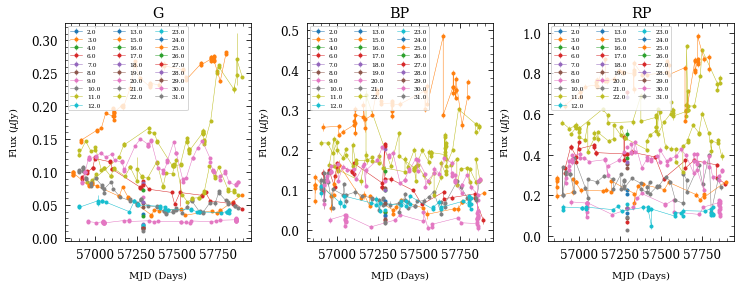

In [21]:
### MAKE FIGURE OF ONE LIGHT CURVE FOR GAIA ###

## First get the ids/names of sources that have Gaia multi-epoch observations.
object_ids = list(df_lc.data.index.levels[0]) # get list of objectids in multiIndex table
#print(object_ids)

fig = plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
axs = [ fig.add_subplot(1,3,ii+1) for ii in range(3) ]
cmap = plt.get_cmap("Spectral")

for dd in object_ids:
    try:
    
        for bb,band in enumerate(["G","BP","RP"]):
        
            this_tab = df_lc.data.loc[dd,"Gaia {}".format(band.lower()),:].reset_index(inplace=False)
            t = Time(this_tab["time"] , format="mjd") # convert to time object
            #axs[bb].plot(t.mjd , this_tab["flux"] , "-" , linewidth=1 , markersize=0.1)
            axs[bb].errorbar(t.mjd , this_tab["flux"] , yerr=this_tab["err"] , fmt="-o",linewidth=0.5 , markersize=3 , label="{}".format(dd))
    except:
        pass

for ii in range(3):
    axs[ii].set_title(np.asarray(["G","BP","RP"])[ii])
    axs[ii].legend(fontsize=6 , ncol=3)
    axs[ii].set_xlabel("MJD (Days)" , fontsize=10)
    axs[ii].set_ylabel(r"Flux ($\mu$Jy)", fontsize=10)

plt.show()

In [22]:
df_lc.data

flux       err
objectid band       time                            
1.0      SAXGRBMGRB 52013.991319  0.100000  0.100000
         zg         58280.446030  0.027914  0.003701
                    58286.443322  0.034589  0.003914
                    58289.434954  0.031590  0.003826
                    58292.441447  0.026130  0.003630
...                                    ...       ...
30.0     Gaia rp    57868.297124  0.317232  0.008274
                    57868.473285  0.322192  0.010622
31.0     Gaia g     57289.819832  0.011247  0.000386
         Gaia bp    57289.819832  0.021577  0.007311
         Gaia rp    57289.819832  0.093032  0.017980

[2229870 rows x 2 columns]

### ASAS-SN (all sky automated survey for supernovae) has a website that can be manually searched (Faisst)
- see if astroquery.vizier can find it



### icecube has a 2008 - 2018 catalog which we can download and is small (Faisst)
- https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018/

## 4. Make plots of luminosity as a function of time
- model plots after https://arxiv.org/pdf/2111.09391.pdf


CPU times: user 149 ms, sys: 8.07 ms, total: 157 ms
Wall time: 156 ms


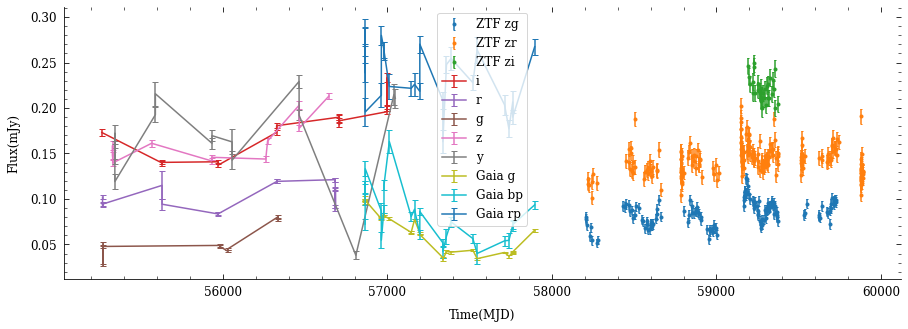

In [23]:
%%time
#pick one to look at for now
obj = 15
singleobj = df_lc.data.loc[(obj),:,:]

#set up for plotting
fig, ax = plt.subplots(figsize=(15,5))

#first check to see which bands we have in the dataframe
availband = singleobj.index.unique('band')
max_list = []

#plot the bands one at a time
for l in range(len(availband)):
    band_lc = singleobj.loc[(obj, availband[l]), :]
    #band_lc = singleobj.loc[availband[l], :] # above line doesn't work for me [ALF]
    band_lc.reset_index(inplace = True)

    #first clean dataframe to remove erroneous rows
    band_lc_clean = band_lc[band_lc['time'] < 65000]

    #before plotting need to scale the Kepler, K2, and TESS fluxes to the other available fluxes
    if availband[l] in ['Kepler', 'K2', 'TESS']:
        #find the maximum value of 'other bands'
        max_electrons = max(band_lc_clean.flux)
        factor = np.mean(max_list)/ max_electrons
        ax.errorbar(band_lc_clean.time, band_lc_clean.flux * factor, band_lc_clean.err* factor, capsize = 3.0,label = availband[l])
    elif availband[l] in ['zg','zr','zi']:
        max_list.append(max(band_lc_clean.flux)) 
        ax.errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err, capsize = 1.0,marker='.',linestyle='', label = 'ZTF '+str(availband[l]))

    else:
        max_list.append(max(band_lc_clean.flux)) 
        ax.errorbar(band_lc_clean.time, band_lc_clean.flux, band_lc_clean.err, capsize = 3.0, label = availband[l])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time(MJD)')
ax.set_ylabel('Flux(mJy)')
plt.legend()

## Image extension: look for archival images of these targets
- NASA NAVO use cases should help us to learn how to do this
- can use the cutout service now in astropy from the first fornax use case

## ML Extension 
Consider training a ML model to do light curve classification based on this sample of CLAGN
 - once we figure out which bands these are likely to be observed in, could then have a optical + IR light curve classifier
 - what would the features of the light curve be?
 - what models are reasonable to test as light curve classifiers?
 - could we make also a sample of TDEs, SNe, flaring AGN? - then train the model to distinguish between these things?
 - need a sample of non-flaring light curves
 
After training the model:
 - would then need a sample of optical + IR light curves for "all" galaxies = big data to run the model on.

Some resources to consider:
- https://github.com/dirac-institute/ZTF_Boyajian
- https://ui.adsabs.harvard.edu/abs/2022AJ....164...68S/abstract
- https://ui.adsabs.harvard.edu/abs/2019ApJ...881L...9F/abstract



## Citations

to the various codes used (astroquery etc.)